In [160]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Load scientific and plotting libraries 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import math

# Load widgets and animation libs 
#from ipywidgets import interact, widgets
#from PIL import Image

# Import random number generators: 
from numpy.random import random
from numpy.random import randn
from numpy.random import randint
from numpy.random import uniform
from numpy.random import choice 
from numpy.random import normal

# Some tools to optimize sim time (work in progress)
import time
from itertools import product
from numba import jit

### Specify parameters of simulation, number of particles, box size,  temperature, curoff distance, thermostat parameters

In [161]:
#-----------------------> LJ parameters in reduced units of sigma and epislon
N = 216 
density=0.5                 # density of Argon LJ spheres 0.5-0.88
L =  (N/density)**(1.0/3.0)

dt = 0.001       # dt : time step
rc2 = 1.e20      # rc2 : squared cutoff distance
nSteps = 10000   # nSteps : number of steps of simulation

T = 1.0          # T : temperature
tau = 0.1        # damping const for Berendsen thermostat
Tdamp = 1        # damping const for standard  thermostat

#------------------> Everything fixed byeond this point

### Vectorize data and store postions, velocities and forces on numpy arrays

In [162]:
pos = np.zeros((3,N))
vel = np.zeros((3,N))
force = np.zeros((3,N))

### Initialize positions and velocities

In [164]:
def initialize_pos_vel(N, L, pos, vel):
    
    """put N particles in a box, using dense packing unit lattice size n3"""
    
    n3 = int(N ** (1 / 3.)) + 1
    iix = iiy = iiz = 0
    
    for i in range(N):
        pos[0][i] = (iix + 0.5) * L / n3
        pos[1][i] = (iiy + 0.5) * L / n3
        pos[2][i] = (iiz + 0.5) * L / n3
        iix += 1
        if iix == n3:
            iix = 0
            iiy += 1
            if iiy == n3:
                iiy = 0
                iiz += 1   
                
    """ Create maxwell Boltzman distribution of velcities"""
    
    vel =  randn(N, 3)
    vel -= np.average(vel, axis=0) # zero mean vel distirbution

def viz_p(pos,L):
    '''Some cheap visualization to see where the particles are located''' 
    
    from mpl_toolkits.mplot3d import axes3d
    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d') 
    
    ax.scatter(pos[0,:], pos[1,:], pos[2,:], s = 200) 
    
    ax.set_xlim3d(0,L)
    ax.set_ylim3d(0,L)
    ax.set_zlim3d(0,L)
    ax.set_xlabel("$X\, [\sigma]$",fontsize=18)
    ax.set_ylabel("$Y\, [\sigma]$",fontsize=18)
    ax.set_zlabel("$Z\, [\sigma]$",fontsize=18)
    ax.set_title("MD snapshot",fontsize=20)

### Visualize lattice

In [158]:
initialize_pos_vel(N, L, pos,vel)
#viz_p(pos,L)

In [159]:
#plt.quiver(pos[0,:],pos[1,:],vel[0,:],vel[1,:])

### Write main helper function of Molecular dynamics

 1. Initalize pos & velocity
 
 2. Evolve velocities (Verlet Algorithm)
 
 3. Enforce PBC
 
 4. Compute Forces, Kinetic and Potential Energies

In [165]:
def velocity_verlet(dt, pos, vel, i):
    """verloctiy verlet algorithm"""
    
    dt2 = dt * dt
    
    pos[0][i] += vel[0][i] * dt + 0.5 * dt2 * force[0][i]
    pos[1][i] += vel[1][i] * dt + 0.5 * dt2 * force[1][i]
    pos[2][i] += vel[2][i] * dt + 0.5 * dt2 * force[2][i]

    vel[0][i] += 0.5 * dt * force[0][i]
    vel[1][i] += 0.5 * dt * force[1][i]
    vel[2][i] += 0.5 * dt * force[2][i]
    
    
def set_pbc(L, pos, i):
    """Enforce Periodic Boundary conditions"""
    
    #Along X
    if pos[0][i] < 0.0:
        pos[0][i] += L
    if pos[0][i] > L:
        pos[0][i] -= L
    #Along Y    
    if pos[1][i] < 0.0:
        pos[1][i] += L
    if pos[1][i] > L:
        pos[1][i] -= L
    #Along Z   
    if pos[2][i] < 0.0:
        pos[2][i] += L
    if pos[2][i] > L:
        pos[2][i] -= L
        
@jit
def potential_energy(N, L, rc2, pos,force):
    """calculate the potential energy"""
    force.fill(0)
    pot_E = 0.0
    
    # First enforce PBC
    halfL = L / 2.0
    
    for i in range(N-1):
        for j in range(i+1, N):
            
            dx = pos[0][i] - pos[0][j]
            dy = pos[1][i] - pos[1][j]
            dz = pos[2][i] - pos[2][j]

            if dx >halfL:                  
                dx -= L
            if dx < -halfL:
                dx += L
            if dy > halfL:
                dy -= L
            if dy < -halfL:
                dy += L
            if dz > halfL:
                dz -= L
            if dz < -halfL:
                dz += L

            r2 = dx * dx + dy * dy + dz * dz
            
            # Evaluate cutoff
            if r2 < rc2:        
                
                r6i = 1.0 / (r2 * r2 * r2)
                pot_E += 4 * (r6i * r6i - r6i)
                f = 48 * (r6i * r6i - 0.5 * r6i)
                
                force[0][i] += dx * f / r2
                force[0][j] -= dx * f / r2
                force[1][i] += dy * f / r2
                force[1][j] -= dy * f / r2
                force[2][i] += dz * f / r2
                force[2][j] -= dz * f / r2
                
    return pot_E


@jit
def kinetic_energy(N, dt, vel, force):
    """calculate the kinetic energy"""
    
    kin_E = 0.0
    
    for i in range(N):
        
        vel[0][i] += 0.5 * dt * force[0][i]
        vel[1][i] += 0.5 * dt * force[1][i]
        vel[2][i] += 0.5 * dt * force[2][i]
        
        kin_E += vel[0][i] * vel[0][i] + vel[1][i] * vel[1][i] + vel[2][i] * vel[2][i]
        
    kin_E *= 0.5
    
    return kin_E


def thermostat(kin_E, T, N, vel):
    """velocity scaling algorithm"""
    
    t = 3.0*kin_E / 2.0 * N
    fac = np.sqrt(T/t)
    
    for i in range(N):
        
        vel[0][i] *= fac
        vel[1][i] *= fac
        vel[2][i] *= fac

def berendsen_thermostat(N, dt, kin_E, vel):
    """berendsen thermostat algorithm"""
    
    lamb = np.sqrt(1 + dt / tau * (T / (2.0 * kin_E / 3.0 / N) - 1.0))
    
    for i in range(N):
        
        vel[0][i] *= lamb
        vel[1][i] *= lamb
        vel[2][i] *= lamb

### You can write functions for outputing thermodynamic data, trajecotries and energies for analyzing at a later time

### Main MD engine

In [166]:
def mdrun(N, L, rc2, dt, nSteps, T, pos,vel,force):
    """main MD function"""
    
    dataPE,dataKE,dataTE=[],[],[]
    
    for s in range(nSteps):
        for i in range(N):
            
            velocity_verlet(dt, pos,vel,i)
            set_pbc(L, pos, i)

        PE = potential_energy(N, L, rc2, pos, force)
        KE = kinetic_energy(N, dt, vel, force)
        TE = PE + KE

        berendsen_thermostat(N, dt, KE, vel)
        
        dataPE.append(PE)
        dataKE.append(KE)
        dataTE.append(TE)
        
    return np.array(dataPE),np.array(dataKE),np.array(dataTE)
   
    
#        output_thermo
#        output_xyz
#        output_Gr

In [167]:
initialize_pos_vel(N, L, pos,vel)

data=mdrun(N, L, rc2, dt, nSteps, T, pos, vel, force)

### Visualize output

In [174]:
#plt.plot(data[0])

In [175]:
#plt.plot(data[1])

In [173]:
#plt.plot(data[2])

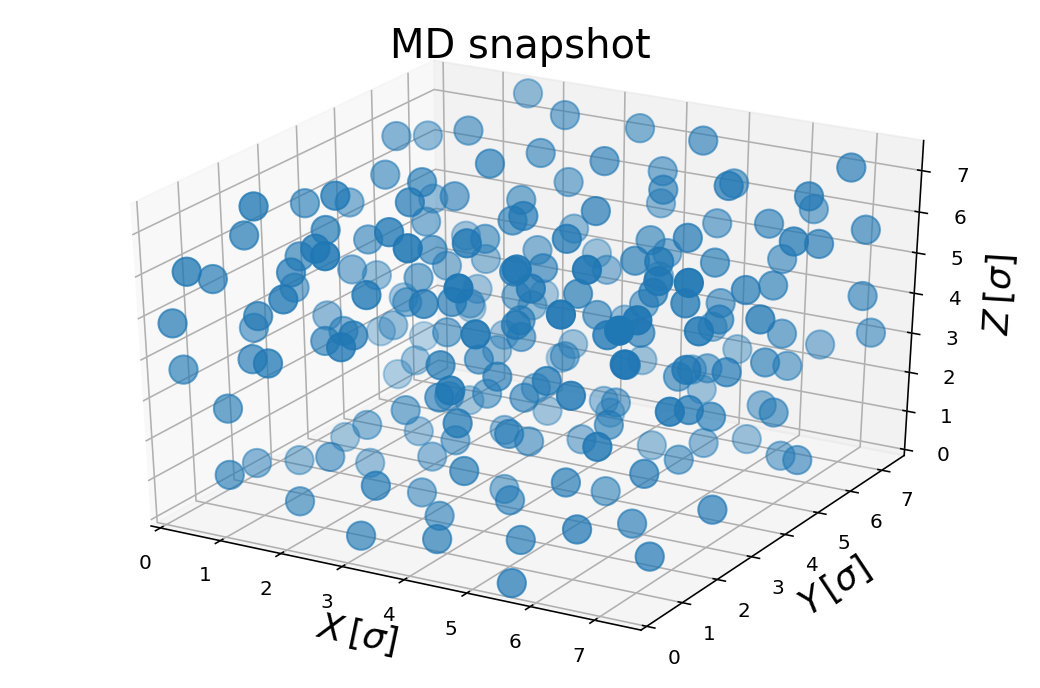

In [176]:
viz_p(pos,L)

In [79]:
'''Run this cell to render our markdown text with beautiful styles.'''
from IPython.core.display import HTML
def set_css_style(css_file_path):
    styles = open(css_file_path, "r").read()
    return HTML(styles)
set_css_style('./common/custom.css')